<h1>speaker diarization google classification</h1>
<h3>Author: Chris Gang Liu </h3>
Notes: Dr. Mohammad Estemd provided suggestions for the guildeline of implementation.<br/>
<b>Problem statement: classify the speakers from audio.</b>
<b>Requirements: Note that each step has two important sub steps.</b>
<ul>
<li>
    Step 1-1: Segment audio</li>
    <li>
Step 1-2: Define a score for meeting evaluation</li>
        <li>
Step 2-1: Cluster text of one speaker</li>
            <li>
Step 2-2: Form three clusters as a report for meeting.</li></ul>


<H3>Our implementation planner</h3>
<ul>
<li>
1. follow the example of https://cloud.google.com/speech-to-text/docs/multiple-voices to segment people based on different voice.</li>
    <li>
2. give the score (actual label value) for example: every queston for each person gains 1 points. Calculate total points.</li>
<hr>
        <li>
3. convert each segment of step 1 to text.</li>
<li>
4. We create excel table with columns: speaker, start sec, end sec from step 3</li>
    <li>
5. for one text (one speaker) of step 3, we cluster text into three clusters. https://nlpforhackers.io/recipe-text-clustering/</li>
        <li>
6. using the same similarity, we cluster other text of step 3. 
(https://stackoverflow.com/questions/50918092/given-cluster-of-documents-compute-similarity-between-corpus-and-the-cluster)</li>
            <li>
7. for each cluster, we utilized metrics of http://www.nltk.org/howto/metrics.html to obtain the distance (Eclidean or Cosine). Based on metrics, we got point of each cluster based on similarity.</li>
                <li>
8. compare with actual points of step 2.</li></ul>

<h2>load libaries</h2>

In [4]:
import pandas as pd

# client = bigquery.Client()
import matplotlib.pyplot as plt
import pandas as pd
import os
import datetime
import numpy as np
import matplotlib as mpl
import statistics
import seaborn as sns #styling plots
import difflib
import math
from scipy import stats
from scipy.stats import mode
import pandas_profiling
    
import IPython
import IPython.display
%matplotlib inline
plt.style.use('ggplot')
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})


In [3]:
#https://sanjayasubedi.com.np/nlp/nlp-with-python-document-clustering/
#https://nlpforhackers.io/recipe-text-clustering/
import pandas as pd
import numpy as np
import re
from textblob import TextBlob

from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import numpy as np
import sklearn.cluster
import distance
import string
from pprint import pprint

#Eliminating features with extremely low frequency
#Keywords which occur in lesser frequency in the corpus usually does not play a role in text classification. 
#One can get rid of these low occurring features, resulting in better performance of the model.
#import necessary library if we didn't
import collections, itertools
import nltk
from nltk.cluster import KMeansClusterer, euclidean_distance
from nltk import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
import nltk.classify.util, nltk.metrics
from nltk.metrics import *
from nltk.classify import NaiveBayesClassifier
from nltk.collocations import BigramCollocationFinder
from nltk.probability import FreqDist, ConditionalFreqDist
from nltk.tokenize import word_tokenize

In [5]:
import warnings

warnings.filterwarnings('ignore')

In [6]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\chris\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\chris\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
#https://towardsdatascience.com/understanding-dimensionality-reduction-for-machine-learning-ad9a3811bd89
#https://medium.com/@dmitriy.kavyazin/principal-component-analysis-and-k-means-clustering-to-visualize-a-high-dimensional-dataset-577b2a7a5fe2
#https://www.kaggle.com/dhanyajothimani/basic-visualization-and-clustering-in-python

### Step 1-1
##### Note: coding was inspired by https://cloud.google.com/speech-to-text/docs/multiple-voices, and we did modification based on updated API usages and our own requirements. 

In [11]:
from google.cloud import speech_v1p1beta1 as speech
from google.cloud.speech_v1p1beta1 import *
from typing import Tuple
import wave

def segment_audio(bucketname='cs6515assignment3', filename='standupMeeting.wav', channel=2, speaker=7) -> str:
    gcs_uri = 'gs://' + bucketname + '/' + filename
    client = speech.SpeechClient()
    audio = RecognitionAudio(uri=gcs_uri)

    config = RecognitionConfig(
        encoding= RecognitionConfig.AudioEncoding.LINEAR16,
        sample_rate_hertz=44100,
        language_code='en-US',
        enable_speaker_diarization=True,
        audio_channel_count=channel,
        diarization_speaker_count=speaker)

    # Detects speech in the audio file
    operation = client.long_running_recognize(config=config, audio=audio)

    response = operation.result(timeout=10000)

    for result in response.results:
        print(result.alternatives[0].transcript)
    
    return operation

In [99]:
response = segment_audio(filename='standupMeeting.wav', channel=2, speaker=7)

I'm the first thing I'm going to move this past year to in progress I think me and Josh are going to start working on this today hopefully and get all the details to the team so I put an estimated time of arrival on that right now
 I actually don't have anything to report except for that I've just been helping out the find the business rules and my only active Pascal be a proven the one story at the end
 I got the list of claim types for the entry screen to the drop-down so I think you were ready to work on coating that so that's ask is now that the values going to be working on the lamp claim entry screen and the only have to revisit it in here until the coast. Call Makoto so soon as the coast completed that will be passing so I'm going to head start on
 these are meters work on getting mad when I can't thank you enough for this past year start on the developing and getting all the artifacts in place for the basalt solution
 so this will be assigned to me
 and I should have this done 

In [100]:
response = response.result(timeout=10000)
response

results {
  alternatives {
    transcript: "I\'m the first thing I\'m going to move this past year to in progress I think me and Josh are going to start working on this today hopefully and get all the details to the team so I put an estimated time of arrival on that right now"
    confidence: 0.9208292
    words {
      start_time {
      }
      end_time {
        nanos: 300000000
      }
      word: "I\'m"
    }
    words {
      start_time {
        nanos: 300000000
      }
      end_time {
        nanos: 500000000
      }
      word: "the"
    }
    words {
      start_time {
        nanos: 500000000
      }
      end_time {
        nanos: 600000000
      }
      word: "first"
    }
    words {
      start_time {
        nanos: 600000000
      }
      end_time {
        seconds: 1
        nanos: 100000000
      }
      word: "thing"
    }
    words {
      start_time {
        seconds: 1
        nanos: 100000000
      }
      end_time {
        seconds: 1
        nanos: 500000000
 

In [101]:
# The transcript within each result is separate and sequential per result.
# However, we need find each word corresponding to speaker:
result = response.results[-1]
words_info = result.alternatives[0].words
# Printing out the output:
for word_info in words_info:
    print(u"word: '{}', start_time: {}, end_time: {}, speaker_tag: {}".format(
        word_info.word, word_info.start_time, word_info.end_time, word_info.speaker_tag))

word: 'I'm', start_time: 0:00:00, end_time: 0:00:00.300000, speaker_tag: 4
word: 'the', start_time: 0:00:00.300000, end_time: 0:00:00.500000, speaker_tag: 4
word: 'first', start_time: 0:00:00.500000, end_time: 0:00:00.600000, speaker_tag: 4
word: 'thing', start_time: 0:00:00.600000, end_time: 0:00:01.100000, speaker_tag: 4
word: 'I'm', start_time: 0:00:01.100000, end_time: 0:00:01.500000, speaker_tag: 4
word: 'going', start_time: 0:00:01.500000, end_time: 0:00:01.600000, speaker_tag: 4
word: 'to', start_time: 0:00:01.600000, end_time: 0:00:01.700000, speaker_tag: 4
word: 'move', start_time: 0:00:01.700000, end_time: 0:00:01.800000, speaker_tag: 4
word: 'this', start_time: 0:00:01.800000, end_time: 0:00:02, speaker_tag: 4
word: 'past', start_time: 0:00:02, end_time: 0:00:02.400000, speaker_tag: 4
word: 'year', start_time: 0:00:02.400000, end_time: 0:00:02.600000, speaker_tag: 4
word: 'to', start_time: 0:00:02.600000, end_time: 0:00:02.700000, speaker_tag: 4
word: 'in', start_time: 0:00:

### Step 1-2 construct excel file based on segments above, then score each speaker

In [106]:
speaker_diarization_df = pd.DataFrame(columns=['member','start','end','text','score'])

In [107]:
from datetime import timedelta
speaker_diarization_df['member'] = [1,2,3,4,5,6,7]
speaker_diarization_df['start'] = None
speaker_diarization_df['end'] =  None
speaker_diarization_df['text'] = ''
speaker_diarization_df['score'] = 0

In [108]:
speaker_diarization_df

,member,start,end,text,score
0,1,None,None,,0
1,2,None,None,,0
2,3,None,None,,0
3,4,None,None,,0
4,5,None,None,,0
5,6,None,None,,0
6,7,None,None,,0


In [109]:
start = speaker_diarization_df['start'].values
end =  speaker_diarization_df['end'].values
text = speaker_diarization_df['text'].values
for word_info in words_info:
    if start[word_info.speaker_tag-1] is None:
        start[word_info.speaker_tag-1] =  word_info.start_time
    if end[word_info.speaker_tag-1] is None:
        end[word_info.speaker_tag-1] = word_info.end_time
    if pd.Timedelta(word_info.end_time) > pd.Timedelta(end[word_info.speaker_tag-1]):
        end[word_info.speaker_tag-1] = word_info.end_time
    text[word_info.speaker_tag-1] = text[word_info.speaker_tag-1] + ' ' + word_info.word
speaker_diarization_df['start'] = start
speaker_diarization_df['end'] = end
speaker_diarization_df['text'] = text

In [110]:
speaker_diarization_df

,member,start,end,text,score
0,1,0 days 00:00:45.200000,0 days 00:01:30.400000,now that the start on the developing,0
1,2,0 days 00:00:58.800000,0 days 00:01:20.200000,here until the coast. Call Makoto so soon as ...,0
2,3,0 days 00:00:47,0 days 00:00:58.800000,values going to be working on the lamp claim ...,0
3,4,0 days 00:00:00,0 days 00:01:21.400000,I'm the first thing I'm going to move this pa...,0
4,5,0 days 00:01:49.900000,0 days 00:02:04.800000,get that done in the next two days so I can g...,0
5,6,0 days 00:01:41.800000,0 days 00:01:49.900000,for the environment and I,0
6,7,0 days 00:01:21.400000,0 days 00:01:41.800000,thank you enough for this past year and getti...,0


In [129]:
scores = []

In [112]:
speaker_diarization_df.loc[0]['text']

' now that the start on the developing'

In [130]:
scores.append(1)

In [113]:
speaker_diarization_df.loc[1]['text']

" here until the coast. Call Makoto so soon as the coast completed that will be passing so I'm going to head start on these are meters work on getting mad when"

In [131]:
scores.append(1)

In [115]:
speaker_diarization_df.loc[2]['text']

' values going to be working on the lamp claim entry screen and the only have to revisit it in'

In [132]:
scores.append(1)

In [117]:
speaker_diarization_df.loc[3]['text']

" I'm the first thing I'm going to move this past year to in progress I think me and Josh are going to start working on this today hopefully and get all the details to the team so I put an estimated time of arrival on that right now I actually don't have anything to report except for that I've just been helping out the find the business rules and my only active Pascal be a proven the one story at the end I got the list of claim types for the entry screen to the drop-down so I think you were ready to work on coating that so that's ask is I can't"

In [133]:
scores.append(3)

In [120]:
speaker_diarization_df.loc[4]['text']

" get that done in the next two days so I can get it to you tomorrow we had some issues with Hydro he just was not able to get his that has tons to reassign that's why I have a new person I'm working with so that maybe in a minute moving forward"

In [134]:
scores.append(2)

In [122]:
speaker_diarization_df.loc[5]['text']

' for the environment and I'

In [135]:
scores.append(0)

In [124]:
speaker_diarization_df.loc[6]['text']

' thank you enough for this past year and getting all the artifacts in place for the basalt solution so this will be assigned to me and I should have this done in two days'

In [136]:
scores.append(1)

In [137]:
speaker_diarization_df['score'] = scores
speaker_diarization_df

,member,start,end,text,score
0,1,0 days 00:00:45.200000,0 days 00:01:30.400000,now that the start on the developing,1
1,2,0 days 00:00:58.800000,0 days 00:01:20.200000,here until the coast. Call Makoto so soon as ...,1
2,3,0 days 00:00:47,0 days 00:00:58.800000,values going to be working on the lamp claim ...,1
3,4,0 days 00:00:00,0 days 00:01:21.400000,I'm the first thing I'm going to move this pa...,3
4,5,0 days 00:01:49.900000,0 days 00:02:04.800000,get that done in the next two days so I can g...,2
5,6,0 days 00:01:41.800000,0 days 00:01:49.900000,for the environment and I,0
6,7,0 days 00:01:21.400000,0 days 00:01:41.800000,thank you enough for this past year and getti...,1


In [138]:
speaker_diarization_df.to_csv('step1segmentsbygoogle.csv')

### Step 2-1 Cluster text of one speaker

In [139]:
step1segments = pd.read_csv('step1segmentsbygoogle.csv')
step1segments

,Unnamed: 0,member,start,end,text,score
0,0,1,0 days 00:00:45.200000,0 days 00:01:30.400000,now that the start on the developing,1
1,1,2,0 days 00:00:58.800000,0 days 00:01:20.200000,here until the coast. Call Makoto so soon as ...,1
2,2,3,0 days 00:00:47,0 days 00:00:58.800000,values going to be working on the lamp claim ...,1
3,3,4,0 days 00:00:00,0 days 00:01:21.400000,I'm the first thing I'm going to move this pa...,3
4,4,5,0 days 00:01:49.900000,0 days 00:02:04.800000,get that done in the next two days so I can g...,2
5,5,6,0 days 00:01:41.800000,0 days 00:01:49.900000,for the environment and I,0
6,6,7,0 days 00:01:21.400000,0 days 00:01:41.800000,thank you enough for this past year and getti...,1


In [140]:
step1segments = step1segments.fillna('')
step1segments

,Unnamed: 0,member,start,end,text,score
0,0,1,0 days 00:00:45.200000,0 days 00:01:30.400000,now that the start on the developing,1
1,1,2,0 days 00:00:58.800000,0 days 00:01:20.200000,here until the coast. Call Makoto so soon as ...,1
2,2,3,0 days 00:00:47,0 days 00:00:58.800000,values going to be working on the lamp claim ...,1
3,3,4,0 days 00:00:00,0 days 00:01:21.400000,I'm the first thing I'm going to move this pa...,3
4,4,5,0 days 00:01:49.900000,0 days 00:02:04.800000,get that done in the next two days so I can g...,2
5,5,6,0 days 00:01:41.800000,0 days 00:01:49.900000,for the environment and I,0
6,6,7,0 days 00:01:21.400000,0 days 00:01:41.800000,thank you enough for this past year and getti...,1


#### we are pick a perfect member lets say index 0, and cluster into 3 

In [141]:
perfectAnswer = step1segments.loc[3]['text']
perfectAnswer

" I'm the first thing I'm going to move this past year to in progress I think me and Josh are going to start working on this today hopefully and get all the details to the team so I put an estimated time of arrival on that right now I actually don't have anything to report except for that I've just been helping out the find the business rules and my only active Pascal be a proven the one story at the end I got the list of claim types for the entry screen to the drop-down so I think you were ready to work on coating that so that's ask is I can't"

In [142]:
vec = TfidfVectorizer(stop_words="english")
vec.fit(perfectAnswer.split())
features = vec.transform(perfectAnswer.split())

In [143]:
cls = MiniBatchKMeans(n_clusters=3, random_state=49)
cls.fit(features)

MiniBatchKMeans(n_clusters=3, random_state=49)

In [144]:
# predict cluster labels for new dataset
cls.predict(features)

# to get cluster labels for the dataset used while
# training the model (used for models that does not
# support prediction on new dataset).
cls.labels_

array([0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0])

In [145]:
# reduce the features to 2D
pca = PCA(n_components=2, random_state=49)
reduced_features = pca.fit_transform(features.toarray())

# reduce the cluster centers to 2D
reduced_cluster_centers = pca.transform(cls.cluster_centers_)

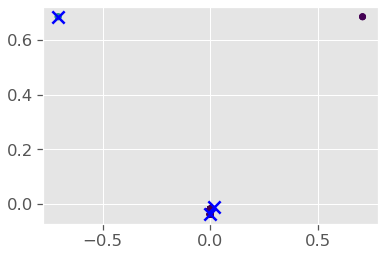

In [146]:
plt.scatter(reduced_features[:,0], reduced_features[:,1], c=cls.predict(features))
plt.scatter(reduced_cluster_centers[:, 0], reduced_cluster_centers[:,1], marker='x', s=150, c='b')

In [63]:
#note, this function is only for filtering stop word, later on, we will have to stem words, and group words
def filterStopWords(text_arr, lang):
    
    # by default it is english lang
    if lang is None:
        lang = 'english'
    new_text_arr = []
    extra_arr = []

    #update existing stop words
    stop_words = set(stopwords.words(lang)) 
    for one_text in text_arr:
        word_tokens = word_tokenize(one_text) 
        one_text_new = [w for w in word_tokens if not w in stop_words] 
        one_text_new = " ".join(one_text_new) 
        new_text_arr.append(one_text_new)
        
    return new_text_arr

In [149]:
#import library if we don't have
from nltk.stem.snowball import SnowballStemmer
#this function will apply stem/lemming to enhance the accuracy of ML model
def stemming(text):
    stemmer = SnowballStemmer("english")
    stemText = ""
    for word in text.split():
        stem = stemmer.stem(word)
        stemText += stem
        stemText += " "
    stemText = stemText.strip()
    return stemText
#usage
#newsitems_gloabl_df_new_new['text'] = newsitems_gloabl_df_new_new['text'].apply(stemming)

In [64]:
# remove puncturation
def filterPuncturation(text):
    import re
    one_text_new = re.sub(r'[?|!|\'|"|#]',r'',text)
    one_text_new = re.sub(r'[.|,|)|(|\|/]',r' ',one_text_new)
    return one_text_new

In [65]:
# remove apostrophe because removing punctation and stopwords cant remove all apostrophe
def filterApostrophe(text):
    return np.char.replace(text,"'", "")

In [66]:
#single characters are not much useful in knowing of the document and few final fingle characters might be irrelevant symbols,
# so it is always good dbe remove the single characters
def filterSingleCharacter(text):
    new_text = ""
    for word in text.split():
        if len(word)>1:
            new_text = new_text + " " + word
    return new_text

In [147]:
#this function will reuse the funcitons we defined above to generate new df
#input parameter: the old dataframe extracted by the first function from xml files
def normalizeMultiLabelsDf(df):
    new_df = df
    #filter puncturation
    new_df['text'] = new_df['text'].apply(filterPuncturation)
    #filter apostroph
    new_df['text'] = new_df['text'].apply(filterApostrophe)
#     filter single chachacter
#     new_df['text'] = new_df['text'].apply(filterSingleCharacter)
    #stem words
    new_df['text'] = new_df['text'].apply(stemming)
    new_df['text'] = filterStopWords(new_df['text'], 'english')
    new_df.to_csv('newsitems_gloabl_df_normalized.csv', index = False, header = True)
    #new_df = normailizeTopics(new_df)
    return new_df;

In [150]:
#usage
step1segments_new = normalizeMultiLabelsDf(step1segments)
step1segments_new['text_vec'] = list(map(lambda x: x.split(" "), step1segments_new['text'].values))#Replace this line
print(step1segments_new)

   Unnamed: 0  member                   start                     end  \
0           0       1  0 days 00:00:45.200000  0 days 00:01:30.400000   
1           1       2  0 days 00:00:58.800000  0 days 00:01:20.200000   
2           2       3         0 days 00:00:47  0 days 00:00:58.800000   
3           3       4         0 days 00:00:00  0 days 00:01:21.400000   
4           4       5  0 days 00:01:49.900000  0 days 00:02:04.800000   
5           5       6  0 days 00:01:41.800000  0 days 00:01:49.900000   
6           6       7  0 days 00:01:21.400000  0 days 00:01:41.800000   

                                                text  score  \
0                                      start develop      1   
1  coast call makoto soon coast complet pass im g...      1   
2  valu go work lamp claim entri screen onli revisit      1   
3  im first thing im go move past year progress t...      3   
4  get done next two day get tomorrow issu hydro ...      2   
5                                    

In [151]:
step1segments_new['text'].values

array(['start develop',
       'coast call makoto soon coast complet pass im go head start meter work get mad',
       'valu go work lamp claim entri screen onli revisit',
       'im first thing im go move past year progress think josh go start work today hope get detail team put estim time arriv right actual dont anyth report except ive help find busi rule onli activ pascal proven one stori end got list claim type entri screen drop-down think readi work coat ask cant',
       'get done next two day get tomorrow issu hydro abl get ton reassign whi new person im work mayb minut move forward',
       'environ',
       'thank enough past year get artifact place basalt solut assign done two day'],
      dtype=object)

In [152]:
perfectAnswer = step1segments.loc[3]['text']
perfectAnswer

'im first thing im go move past year progress think josh go start work today hope get detail team put estim time arriv right actual dont anyth report except ive help find busi rule onli activ pascal proven one stori end got list claim type entri screen drop-down think readi work coat ask cant'

In [153]:
perfectAnswer_token = step1segments.loc[3]['text_vec']
perfectAnswer_token

['im',
 'first',
 'thing',
 'im',
 'go',
 'move',
 'past',
 'year',
 'progress',
 'think',
 'josh',
 'go',
 'start',
 'work',
 'today',
 'hope',
 'get',
 'detail',
 'team',
 'put',
 'estim',
 'time',
 'arriv',
 'right',
 'actual',
 'dont',
 'anyth',
 'report',
 'except',
 'ive',
 'help',
 'find',
 'busi',
 'rule',
 'onli',
 'activ',
 'pascal',
 'proven',
 'one',
 'stori',
 'end',
 'got',
 'list',
 'claim',
 'type',
 'entri',
 'screen',
 'drop-down',
 'think',
 'readi',
 'work',
 'coat',
 'ask',
 'cant']

## Train the NLTK model
##### coding references: https://www.kdnuggets.com/2018/04/robust-word2vec-models-gensim.html

In [72]:
from gensim.models import Word2Vec

#### Find the similar words to the perfect answers we selected. 

In [154]:
# # tokenize sentences in corpus
# wpt = nltk.WordPunctTokenizer()
# tokenized_corpus = [wpt.tokenize(document) for document in norm_bible]

# Set values for various parameters
feature_size = 100    # Word vector dimensionality  
window_context = 30          # Context window size                                                                                    
min_word_count = 1   # Minimum word count                        
sample = 1e-3   # Downsample setting for frequent words

w2v_model = Word2Vec(step1segments_new['text_vec'].values, size=feature_size, 
                          window=window_context, min_count=min_word_count,
                          sample=sample, iter=50)

# view similar words based on gensim's model
similar_words = {search_term: [item[0] for item in w2v_model.wv.most_similar([search_term], topn=5)]
                  for search_term in perfectAnswer_token}
similar_words

{'im': ['get', 'team', 'go', 'stori', 'list'],
 'first': ['get', 'type', 'team', 'ive', 'progress'],
 'thing': ['readi', 'start', 'progress', 'put', 'busi'],
 'go': ['team', 'get', 'ive', 'im', 'start'],
 'move': ['actual', 'right', 'work', 'team', 'readi'],
 'past': ['stori', 'get', 'minut', 'find', 'estim'],
 'year': ['progress', 'past', 'drop-down', 'proven', 'coat'],
 'progress': ['drop-down', 'year', 'dont', 'ask', 'think'],
 'think': ['cant', 'team', 'today', 'get', 'progress'],
 'josh': ['stori', 'actual', 'team', 'get', 'put'],
 'start': ['team', 'actual', 'work', 'go', 'get'],
 'work': ['team', 'readi', 'help', 'ask', 'actual'],
 'today': ['pascal', 'ive', 'work', 'minut', 'think'],
 'hope': ['past', 'ask', 'claim', 'team', 'think'],
 'get': ['team', 'im', 'stori', 'go', 'actual'],
 'detail': ['stori', 'work', 'start', 'dont', 'move'],
 'team': ['work', 'get', 'actual', 'put', 'go'],
 'put': ['team', 'readi', 'tomorrow', 'got', 'im'],
 'estim': ['reassign', 'past', 'right', 'a

In [155]:
X = w2v_model[w2v_model.wv.vocab]

In [156]:
print (list(w2v_model.wv.vocab))
print (len(list(w2v_model.wv.vocab)))

['start', 'develop', 'coast', 'call', 'makoto', 'soon', 'complet', 'pass', 'im', 'go', 'head', 'meter', 'work', 'get', 'mad', 'valu', 'lamp', 'claim', 'entri', 'screen', 'onli', 'revisit', 'first', 'thing', 'move', 'past', 'year', 'progress', 'think', 'josh', 'today', 'hope', 'detail', 'team', 'put', 'estim', 'time', 'arriv', 'right', 'actual', 'dont', 'anyth', 'report', 'except', 'ive', 'help', 'find', 'busi', 'rule', 'activ', 'pascal', 'proven', 'one', 'stori', 'end', 'got', 'list', 'type', 'drop-down', 'readi', 'coat', 'ask', 'cant', 'done', 'next', 'two', 'day', 'tomorrow', 'issu', 'hydro', 'abl', 'ton', 'reassign', 'whi', 'new', 'person', 'mayb', 'minut', 'forward', 'environ', 'thank', 'enough', 'artifact', 'place', 'basalt', 'solut', 'assign']
87


In [157]:
X

array([[ 0.00077734,  0.00315163, -0.00099939, ...,  0.00278141,
        -0.00087173,  0.00509126],
       [-0.0003421 ,  0.00315108,  0.00430941, ..., -0.0020424 ,
        -0.00356727,  0.00235554],
       [-0.00254602, -0.00374563,  0.00280935, ...,  0.00257709,
         0.00464883, -0.00113031],
       ...,
       [-0.00453368,  0.0032433 , -0.00431347, ..., -0.00009293,
         0.00077744, -0.00080823],
       [-0.00124594,  0.0040763 , -0.00299804, ...,  0.0014767 ,
        -0.00158758,  0.00093386],
       [-0.0025519 , -0.00215823,  0.0029732 , ...,  0.00255678,
        -0.00124662, -0.00186662]], dtype=float32)

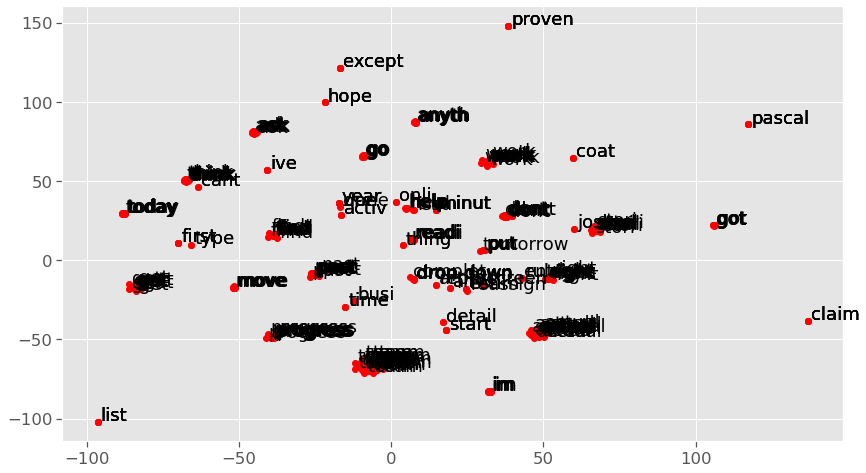

In [158]:
from sklearn.manifold import TSNE

words = sum([[k] + v for k, v in similar_words.items()], [])
wvs = w2v_model.wv[words]

tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=2)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1], c='red', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

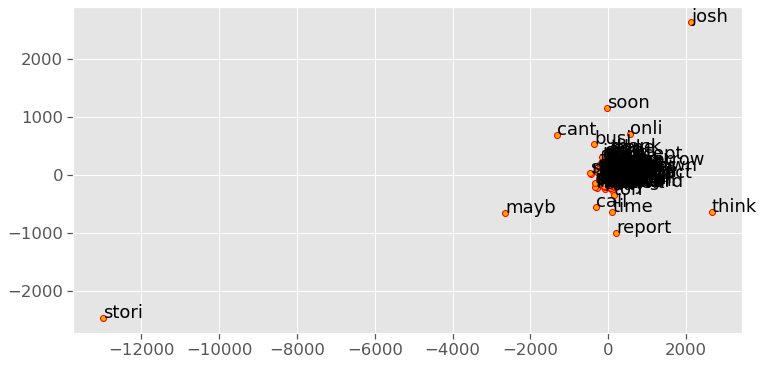

In [159]:
# visualize embeddings
from sklearn.manifold import TSNE

words = w2v_model.wv.index2word
wvs = w2v_model.wv[words]

tsne = TSNE(n_components=2, random_state=0, n_iter=5000, perplexity=2)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(12, 6))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

In [160]:
def average_word_vectors(words, model, vocabulary, num_features):
    
    feature_vector = np.zeros((num_features,),dtype="float64")
    nwords = 0.
    
    for word in words:
        if word in vocabulary: 
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model[word])
    
    if nwords:
        feature_vector = np.divide(feature_vector, nwords)
        
    return feature_vector
    
def averaged_word_vectorizer(corpus, model, num_features):
    vocabulary = set(model.wv.index2word)
    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features)
                    for tokenized_sentence in corpus]
    return np.array(features)

In [161]:
# get document level embeddings
w2v_feature_array = averaged_word_vectorizer(corpus=step1segments_new['text_vec'].values, model=w2v_model,
                                             num_features=feature_size)
pd.DataFrame(w2v_feature_array)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.000218,0.003151,0.001655,0.000889,0.001621,-0.000966,0.000513,-0.001093,0.002589,-0.002532,...,0.000350,-0.001888,-0.001669,-0.001991,-0.000120,0.000864,-0.004393,0.000370,-0.002220,0.003723
1,-0.000202,-0.000170,0.001840,-0.001130,0.000931,-0.000320,0.000597,-0.000360,0.000389,-0.001264,...,-0.002685,-0.000557,0.001580,-0.000656,0.000448,0.002604,-0.000269,0.000584,0.001087,0.002205
2,0.000949,-0.000955,-0.000658,-0.000515,0.001887,0.000732,-0.000973,0.001003,0.001140,-0.000074,...,-0.001609,-0.000186,0.002150,-0.002927,0.001072,0.003059,-0.001952,-0.000482,0.001370,0.002724
3,-0.000035,0.000634,0.000765,-0.000652,0.001398,0.001220,-0.000620,0.000480,-0.000490,-0.000682,...,-0.002746,-0.000362,0.003352,-0.001666,0.000044,0.004047,-0.000186,-0.000465,0.002268,0.001998
4,0.000347,-0.000529,0.000041,0.000873,0.000644,0.001367,-0.000545,0.001155,0.000548,-0.000382,...,-0.002315,0.000291,0.001539,-0.001176,0.000055,0.003176,-0.000102,-0.000788,0.001975,0.002412
5,-0.000262,-0.003798,-0.003579,-0.004001,0.003015,0.003815,-0.004217,0.002986,-0.000101,0.003090,...,0.004055,0.000121,-0.002565,-0.001855,-0.002208,-0.001401,0.003692,-0.000580,-0.001647,0.003007
6,0.000355,-0.000793,-0.000424,0.001270,0.001011,0.001505,-0.000360,0.000520,0.000527,-0.000855,...,-0.002862,0.001908,0.001967,-0.000411,-0.000339,0.003231,0.000061,-0.000420,0.001777,0.000799


In [ ]:
# print (model.similarity('past', 'claim'))
# print (model.similarity('bug', 'today'))
# print (model.most_similar(positive=['yesterday'], negative=[], topn=2))
# print (model['fix'])

K Means Clustering with NLTK Library

In [162]:
def trainModelBasedOnKMeans(distance=nltk.cluster.util.cosine_distance, repeats=100, clusters=3):
    kclusterer = KMeansClusterer(clusters, distance=distance, repeats=repeats)
    assigned_clusters = kclusterer.cluster(X, assign_clusters=True)
    print (assigned_clusters)
    return kclusterer, assigned_clusters

In [163]:
# trained with euclidean_distance
kclusterer_euclidean, assigned_clusters_euclidean = trainModelBasedOnKMeans(distance=nltk.cluster.util.euclidean_distance)

[2, 0, 1, 1, 0, 0, 0, 0, 2, 2, 0, 0, 2, 2, 0, 0, 1, 2, 2, 2, 2, 0, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 1, 2, 2, 2, 2, 0, 1, 0, 0, 2, 2, 2, 2, 2, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 2, 1, 1, 1, 0, 1, 0, 0, 0, 0]


In [164]:
# trained with cosine_distance
kclusterer, assigned_clusters = trainModelBasedOnKMeans()

[2, 2, 0, 2, 2, 2, 2, 1, 2, 0, 0, 2, 1, 1, 2, 1, 1, 1, 0, 2, 1, 1, 0, 1, 1, 2, 2, 2, 0, 1, 0, 0, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 0, 0, 2, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 2, 0, 1, 1, 1, 1, 2, 1, 2, 0, 1, 2, 0, 1, 1, 2, 2, 1, 2, 0, 1, 2, 1, 1, 2, 1, 1, 1, 0, 0, 0]


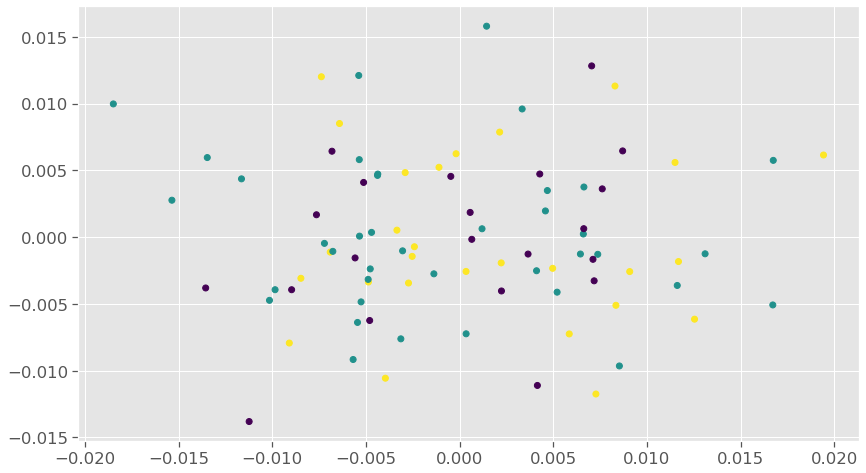

In [165]:
pca = PCA(n_components=2).fit(X)
pca_2d = pca.transform(X)
plt.figure('K-means with 3 clusters',figsize=(14, 8))
plt.scatter(pca_2d[:, 0], pca_2d[:, 1], c=assigned_clusters)
plt.show()

## Step 2-2 - clustering text as three categories: work done, planned work and issues; Moveover, we scored each speaker's answers based on different metric

In [166]:
step1segments_new

,Unnamed: 0,member,start,end,text,score,text_vec
0,0,1,0 days 00:00:45.200000,0 days 00:01:30.400000,start develop,1,"[start, develop]"
1,1,2,0 days 00:00:58.800000,0 days 00:01:20.200000,coast call makoto soon coast complet pass im g...,1,"[coast, call, makoto, soon, coast, complet, pa..."
2,2,3,0 days 00:00:47,0 days 00:00:58.800000,valu go work lamp claim entri screen onli revisit,1,"[valu, go, work, lamp, claim, entri, screen, o..."
3,3,4,0 days 00:00:00,0 days 00:01:21.400000,im first thing im go move past year progress t...,3,"[im, first, thing, im, go, move, past, year, p..."
4,4,5,0 days 00:01:49.900000,0 days 00:02:04.800000,get done next two day get tomorrow issu hydro ...,2,"[get, done, next, two, day, get, tomorrow, iss..."
5,5,6,0 days 00:01:41.800000,0 days 00:01:49.900000,environ,0,[environ]
6,6,7,0 days 00:01:21.400000,0 days 00:01:41.800000,thank enough past year get artifact place basa...,1,"[thank, enough, past, year, get, artifact, pla..."


In [167]:
#
step1segments_new_2_2 = step1segments_new.copy()
current_str_0_arr = []
current_str_1_arr = []
current_str_2_arr = []
for i in range(0, len(step1segments_new)):
    current_str_0 = ' '
    current_str_1 = ' '
    current_str_2 = ' '
    for word in step1segments_new.loc[i]['text_vec']:
        if word in words:
            word_index =  words.index(word)
            word_cluster = assigned_clusters[word_index]
            if word_cluster == 0:
                current_str_0 = current_str_0 + ' ' + word
            if word_cluster == 1:
                current_str_1 = current_str_1 + ' ' + word
            if word_cluster == 2:
                current_str_2 = current_str_2 + ' ' + word
    current_str_0_arr.append(current_str_0)
    current_str_1_arr.append(current_str_1)
    current_str_2_arr.append(current_str_2)

        

check 1) work has been done 2)
work planned to do 3) reported issues.

In [168]:
print(current_str_0_arr)
print(current_str_1_arr)
print(current_str_2_arr)

[' ', '  call pass im', '  onli revisit', '  im thing im move progress dont anyth busi onli activ pascal proven end cant', '  issu person im move', ' ', '  basalt solut assign']
['  develop', '  soon complet head meter', '  entri', '  first year think josh today hope time arriv right actual except ive help find rule one got list type entri drop-down think coat', '  next two day hydro abl whi mayb forward', '  environ', '  enough year artifact place two day']
['  start', '  coast makoto coast go start work get mad', '  valu go work lamp claim screen', '  go past go start work get detail team put estim report stori claim screen readi work ask', '  get done get tomorrow get ton reassign new work minut', ' ', '  thank past get done']


from above, 
<ul>
    <li>
        current_str_2_arr talked about 1) work has been done; </li><li>current_str_1_arr talked about 2)work planned to do; </li><li>current_str_0_arr talked about 3) reported issues
    </li></ul>

In [169]:
step1segments_new_2_2['reported_issue'] = current_str_0_arr
step1segments_new_2_2['planned_do'] = current_str_1_arr
step1segments_new_2_2['work_done'] = current_str_2_arr

In [170]:
# step1segments_new_2_2= step1segments_new_2_2.drop([0,1,2], axis=1)
step1segments_new_2_2

,Unnamed: 0,member,start,end,text,score,text_vec,reported_issue,planned_do,work_done
0,0,1,0 days 00:00:45.200000,0 days 00:01:30.400000,start develop,1,"[start, develop]",,develop,start
1,1,2,0 days 00:00:58.800000,0 days 00:01:20.200000,coast call makoto soon coast complet pass im g...,1,"[coast, call, makoto, soon, coast, complet, pa...",call pass im,soon complet head meter,coast makoto coast go start work get mad
2,2,3,0 days 00:00:47,0 days 00:00:58.800000,valu go work lamp claim entri screen onli revisit,1,"[valu, go, work, lamp, claim, entri, screen, o...",onli revisit,entri,valu go work lamp claim screen
3,3,4,0 days 00:00:00,0 days 00:01:21.400000,im first thing im go move past year progress t...,3,"[im, first, thing, im, go, move, past, year, p...",im thing im move progress dont anyth busi on...,first year think josh today hope time arriv ...,go past go start work get detail team put es...
4,4,5,0 days 00:01:49.900000,0 days 00:02:04.800000,get done next two day get tomorrow issu hydro ...,2,"[get, done, next, two, day, get, tomorrow, iss...",issu person im move,next two day hydro abl whi mayb forward,get done get tomorrow get ton reassign new w...
5,5,6,0 days 00:01:41.800000,0 days 00:01:49.900000,environ,0,[environ],,environ,
6,6,7,0 days 00:01:21.400000,0 days 00:01:41.800000,thank enough past year get artifact place basa...,1,"[thank, enough, past, year, get, artifact, pla...",basalt solut assign,enough year artifact place two day,thank past get done


## as we can see member 2 seemed to answer perfectly, because he/she points out "yesterday" work_done, "today" planned_do and some "issu" keywords in reported_issue 
#### Therefore, we will evaulate others answers automatically based on selected metrics [http://www.nltk.org/howto/metrics.html]

In [171]:
#using the 4th person as the reference answers
Reference_work_done = step1segments_new_2_2.loc[3]['work_done']
Reference_planned_do= step1segments_new_2_2.loc[3]['planned_do']
Reference_reported_issue= step1segments_new_2_2.loc[3]['reported_issue']
print('Reference_work_done', Reference_work_done)
print('Reference_planned_do', Reference_planned_do)
print('Reference_reported_issue', Reference_reported_issue)

Reference_work_done   go past go start work get detail team put estim report stori claim screen readi work ask
Reference_planned_do   first year think josh today hope time arriv right actual except ive help find rule one got list type entri drop-down think coat
Reference_reported_issue   im thing im move progress dont anyth busi onli activ pascal proven end cant


In [172]:
len(step1segments_new_2_2)

7

In [173]:
step1segments_new_2_2.loc[3]

Unnamed: 0                                                        3
member                                                            4
start                                               0 days 00:00:00
end                                          0 days 00:01:21.400000
text              im first thing im go move past year progress t...
score                                                             3
text_vec          [im, first, thing, im, go, move, past, year, p...
reported_issue      im thing im move progress dont anyth busi on...
planned_do          first year think josh today hope time arriv ...
work_done           go past go start work get detail team put es...
Name: 3, dtype: object

##### Try building the vectors before feeding them to the cosine_distance function:

In [183]:
import math
from collections import Counter
from nltk import cluster

def similar(l1, l2, metric=cluster.util.cosine_distance):
    iterable1 = l1.split()
    iterable2 = l2.split()
    counter1 = Counter(iterable1)
    counter2= Counter(iterable2)
    all_items = set(counter1.keys()).union( set(counter2.keys()) )
    vector1 = [counter1[k] for k in all_items]
    vector2 = [counter2[k] for k in all_items]
    s1 = set(iterable1)
    s2 = set(iterable2)
    result_metric = None
    if metric == cluster.util.cosine_distance:
        result_metric = metric(vector1, vector2)
    else:
        result_metric = metric(s1, s2)
#     print(s1, s2)
#     print("Binary distance:", binary_distance(s1, s2))
#     print("Jaccard distance:", jaccard_distance(s1, s2))
#     print("MASI distance:", masi_distance(s1, s2))
    return result_metric


##### initilize scores of each questions

In [174]:

AI_score_total = []

##### give scores of each questions automatically based on metrics cosine_distance

In [184]:
def getAIScoreByMetric(df, metric):
    AI_score_total = []
    for i in range(0, len(df)):
        Sample_work_done = df.loc[i]['work_done']
        Sample_planned_do= df.loc[i]['planned_do']
        Sample_reported_issue= df.loc[i]['reported_issue']
        work_done_score = 1 - similar(Reference_work_done, Sample_work_done, metric)
        planned_do_score = 1 - similar(Reference_planned_do, Sample_planned_do, metric)
        reported_issue_socre = 1- similar(Reference_reported_issue, Sample_reported_issue, metric)
        AI_score_total.append(work_done_score + planned_do_score + reported_issue_socre)
    return AI_score_total


def scoreByAI(df):
    df['cosine_similiary(distance)_score_total'] = getAIScoreByMetric(df, cluster.util.cosine_distance)
#  )   df['euclidean_distance_score_total'] = getAIScoreByMetric(df, cluster.util.euclidean_distance)
    df['binary_similiary(distance)_score_total'] = getAIScoreByMetric(df, binary_distance)
    df['jaccard_similiary(distance)_score_total'] = getAIScoreByMetric(df, jaccard_distance)
    df['masi_similiary(distance)_score_total'] = getAIScoreByMetric(df, masi_distance)

    return df

In [187]:
step1segments_new_2_2 = scoreByAI(step1segments_new_2_2)
step1segments_new_2_2

,Unnamed: 0,member,start,end,text,score,text_vec,reported_issue,planned_do,work_done,cosine_similiary(distance)_score_total,binary_similiary(distance)_score_total,jaccard_similiary(distance)_score_total,masi_similiary(distance)_score_total
0,0,1,0 days 00:00:45.200000,0 days 00:01:30.400000,start develop,1,"[start, develop]",,develop,start,NaN,0.0,0.066667,0.044667
1,1,2,0 days 00:00:58.800000,0 days 00:01:20.200000,coast call makoto soon coast complet pass im g...,1,"[coast, call, makoto, soon, coast, complet, pa...",call pass im,soon complet head meter,coast makoto coast go start work get mad,0.702714,0.0,0.288889,0.095333
2,2,3,0 days 00:00:47,0 days 00:00:58.800000,valu go work lamp claim entri screen onli revisit,1,"[valu, go, work, lamp, claim, entri, screen, o...",onli revisit,entri,valu go work lamp claim screen,0.911299,0.0,0.352177,0.131673
3,3,4,0 days 00:00:00,0 days 00:01:21.400000,im first thing im go move past year progress t...,3,"[im, first, thing, im, go, move, past, year, p...",im thing im move progress dont anyth busi on...,first year think josh today hope time arriv ...,go past go start work get detail team put es...,3.000000,3.0,3.000000,3.000000
4,4,5,0 days 00:01:49.900000,0 days 00:02:04.800000,get done next two day get tomorrow issu hydro ...,2,"[get, done, next, two, day, get, tomorrow, iss...",issu person im move,next two day hydro abl whi mayb forward,get done get tomorrow get ton reassign new w...,0.647772,0.0,0.228571,0.075429
5,5,6,0 days 00:01:41.800000,0 days 00:01:49.900000,environ,0,[environ],,environ,,NaN,0.0,0.000000,0.000000
6,6,7,0 days 00:01:21.400000,0 days 00:01:41.800000,thank enough past year get artifact place basa...,1,"[thank, enough, past, year, get, artifact, pla...",basalt solut assign,enough year artifact place two day,thank past get done,0.299868,0.0,0.154684,0.051046
